In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaidmazen879/plant-village")

print("Path to dataset files:", path)

In [1]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
#LOADING THE DATASET

In [2]:

# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 300

# Path to the dataset folder
root_dir = 'PlantDiseaseDataset/PlantVillage'


train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')


In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Background_without_leaves ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry___healthy ...
[INFO] Processing Cherry___Powdery_mildew ...
[INFO] Processing Corn___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn___Common_rust ...
[INFO] Processing Corn___healthy ...
[INFO] Processing Corn___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[IN

In [5]:
# label_binarizer = pickle.load(open('plant_disease_label_transform.pkl', 'rb'))
# image_labels = label_binarizer.transform(label_list)

# n_classes = len(label_binarizer.classes_)

# print("Total number of classes: ", n_classes)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


In [6]:
label_binarizer = pickle.load(open('plant_disease_label_transform.pkl', 'rb'))
image_labels = label_binarizer.transform(label_list)

n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)
print(label_binarizer.classes_)

Total number of classes:  39
['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Background_without_leaves' 'Blueberry___healthy'
 'Cherry___Powdery_mildew' 'Cherry___healthy'
 'Corn___Cercospora_leaf_spot Gray_leaf_spot' 'Corn___Common_rust'
 'Corn___Northern_Leaf_Blight' 'Corn___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_L

In [7]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [8]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


In [9]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [10]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

C:\Users\trish\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 85, 85, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 58,127,271 (221.74 MB)

 Trainable params: 58,124,391 (221.73 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [12]:
# ... other imports and model definition ...

# Initialize optimizer
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(
    augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    steps_per_epoch=len(x_train)//BATCH_SIZE,
    verbose=1
)

C:\Users\trish\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


[INFO] Training network...


C:\Users\trish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.0886 - loss: 0.5237 - val_accuracy: 0.1011 - val_loss: 0.1366
Epoch 2/25
  1/283 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.3438 - loss: 0.1052

C:\Users\trish\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.3438 - loss: 0.1052 - val_accuracy: 0.1002 - val_loss: 0.1361
Epoch 3/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.4120 - loss: 0.0898 - val_accuracy: 0.4327 - val_loss: 0.0779
Epoch 4/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.5000 - loss: 0.0611 - val_accuracy: 0.4238 - val_loss: 0.0793
Epoch 5/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.5459 - loss: 0.0685 - val_accuracy: 0.2291 - val_loss: 0.1941
Epoch 6/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.4688 - loss: 0.0716 - val_accuracy: 0.2172 - val_loss: 0.2019
Epoch 7/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.6483 - loss: 0.0560 - val_accuracy: 0.2980 - val_loss: 0.1325
Epoch 8/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5938 - loss: 0.0733 - val_accuracy: 0.3413 - val_loss: 0.1221
Epoch 9/25
283/283 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.6827 - loss: 0.0493 - val_accuracy: 0

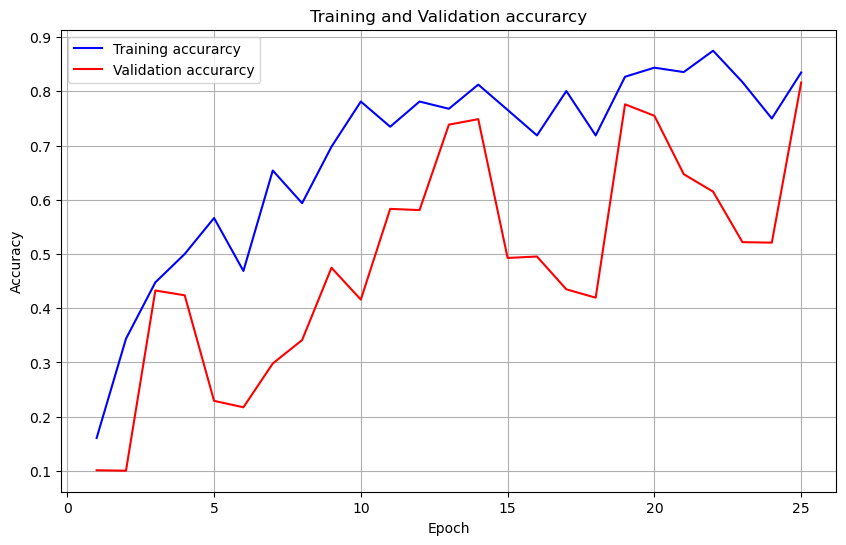

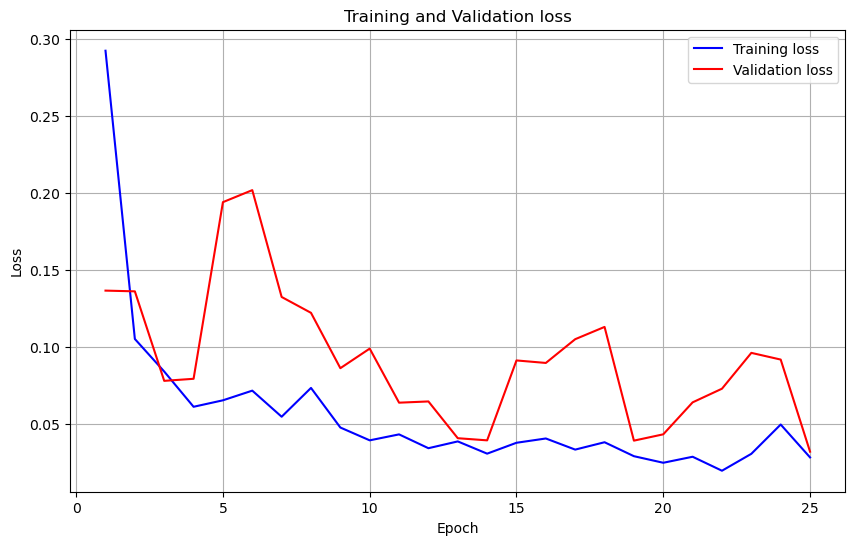

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)



# Train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - accuracy: 0.8051 - loss: 0.0323
Test Accuracy: 81.63355588912964


In [15]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model001.pkl', 'wb'))

[INFO] Saving model...


In [16]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [19]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict(np_image)
#     print(result)
#     print(np.sum(result[0]))
    pred_class=np.argmax(result[0])
#     print(pred_class)
    predicted_class_label = label_binarizer.classes_[pred_class]
    print(predicted_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tomato___Leaf_Mold


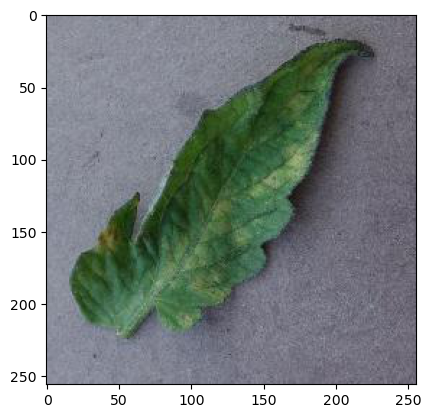

In [24]:
predict_disease(r"C:\Users\trish\Downloads\PlantDiseaseDataset\PlantVillage\val\Tomato___Leaf_Mold\image (98).JPG")

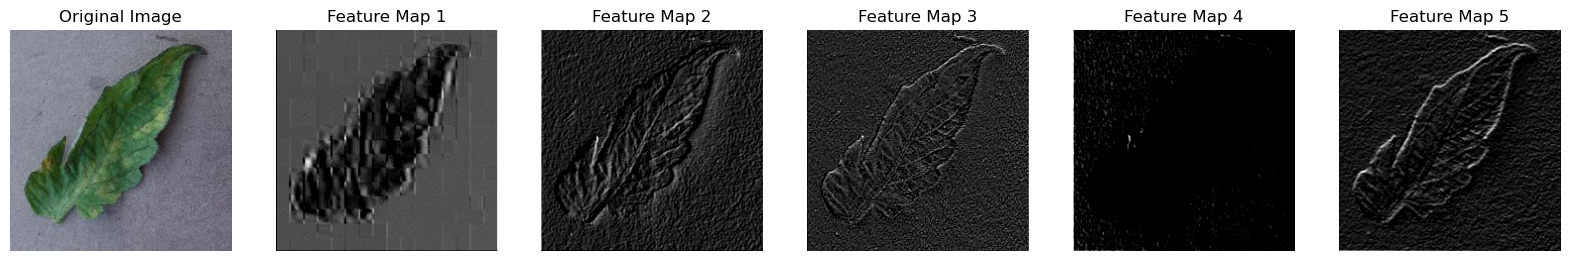

In [57]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image

# Step 1: Load the image and preprocess it
img_path = r"C:\Users\trish\Downloads\PlantDiseaseDataset\PlantVillage\val\Tomato___Leaf_Mold\image (98).JPG"  # replace with your image path
img = Image.open(img_path)

# Define image transformation (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Step 2: Load pre-trained model (e.g., VGG16)
model = models.vgg16(pretrained=True)
model.eval()

# Step 3: Hook to capture outputs from layers
activations = []

def hook_fn(module, input, output):
    activations.append(output)

# Register hooks for the layers you want to visualize (e.g., convolutional layers)
hook_handles = []
for name, layer in model.features._modules.items():
    hook_handles.append(layer.register_forward_hook(hook_fn))

# Step 4: Forward pass through the model and capture activations
with torch.no_grad():
    _ = model(img_tensor)

# Step 5: Visualize the activations
# Let's visualize the activations from the first convolutional layer
first_layer_output = activations[0]  # Output of the first conv layer
n_features = first_layer_output.size(1)

# Plot some of the feature maps (e.g., 5 of them)
plt.figure(figsize=(20, 10))

# Plot the original image first
plt.subplot(1, 6, 1)
plt.imshow(img)  # Assuming original_image is already defined
plt.title("Original Image")
plt.axis('off')

# Then plot the feature maps of the first layer
for i in range(min(n_features, 5)):  # Adjust the range as needed
    plt.subplot(1, 6, i + 2)
    plt.imshow(first_layer_output[0, i].cpu(), cmap='gray')
    plt.title(f"Feature Map {i+1}")  # You can modify the title based on your preference
    plt.axis('off')

# Display the plot
plt.show()

# Clean up hooks after use
for handle in hook_handles:
    handle.remove()

